In [1]:
## Import required Python modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy, scipy.stats
import io
import base64
#from IPython.core.display import display
from IPython.display import display, HTML, Image
from urllib.request import urlopen

try:
    import astropy as apy
    import astropy.table
    _apy = True
    #print('Loaded astropy')
except:
    _apy = False
    #print('Could not load astropy')

## Customising the font size of figures
plt.rcParams.update({'font.size': 14})

## Customising the look of the notebook
display(HTML("<style>.container { width:95% !important; }</style>"))
## This custom file is adapted from https://github.com/lmarti/jupyter_custom/blob/master/custom.include
HTML('custom.css')
#HTML(urlopen('https://raw.githubusercontent.com/bretonr/intro_data_science/master/custom.css').read().decode('utf-8'))

In [2]:
## Custom imports
from scipy.stats import binom, poisson, chi2, norm, uniform
from scipy.optimize import curve_fit
from math import ceil, pi
from numpy import exp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Rectangle
#from matplotlib.colors import makeMappingArray
from matplotlib.cm import jet
import pandas as pd
from tqdm import trange

In [3]:
## Adding a button to hide the Python source code
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>''')

<div class="container-fluid">
    <div class="row">
        <div class="col-md-8" align="center">
            <h1>PHYS 10792: Introduction to Data Science</h1>
            <!--<h3>2019-2020 Academic Year</h3><br>-->
        </div>
        <div class="col-md-3">
            <img align='center' style="border-width:0" src="images/UoM_logo.png"/>
        </div>
    </div>
</div>

<div class="container-fluid">
    <div class="row">
        <div class="col-md-2" align="right">
            <b>Course instructors:&nbsp;&nbsp;</b>
        </div>
        <div class="col-md-9" align="left">
            <a href="http://www.ajmarkwick.net/">Dr. Andrew Markwick</a> - Twitter <a href="https://twitter.com/AndrewMarkwick">@AndrewMarkwick</a><br>
            <a href="http://www.hep.manchester.ac.uk/u/gersabec">Prof. Marco Gersabeck</a> - Twitter <a href="https://twitter.com/MarcoGersabeck">@MarcoGersabeck</a>
        </div>
    </div>
</div>

# Chapter 10

## Syllabus

1. Probabilities and interpretations
2. Probability distributions
3. Parameter estimation
4. Maximum likelihood
5. Least square, chi2, correlations
6. Monte Carlo basics
7. Goodness of fit tests
8. Hypothesis testing
9. Probability and confidence level
10. **Limit setting**
11. Introduction to multivariate analysis techniques

## Topics

**[10 Limit setting](#10-Limit-setting)**

**[10.1 Coverage](#10.1-Coverage)**
- 10.1.1 Definition of coverage
- 10.1.2 Measurement of a constrained quantity

**[10.2 The issue of flip-flopping](#10.2-The-issue-of-flip-flopping)**
- 10.2.1 Combining different approaches
- 10.2.2 Flip-flopping
- 10.2.3 Poisson belts

**[10.3 The Feldman-Cousins method](#10.3-The-Feldman-Cousins-method)**
- 10.3.1 Description of the method and application to Poisson intervals
- 10.3.2 Application to Gaussian confidence belts

## 10 Limit setting

We discussed confidence levels in Chapters 8 and 9. These were mostly discussed in scenarios not affected by limitations of the parameters that are being assessed. In this part we cover the somewhat more complicated situation when physical boundaries apply, e.g. that a quantity has to be positive (e.g. a mass).

This Chapter largely follows a paper by Feldman and Cousins: <a href="https://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.3873">Phys. Rev. D57 (1998) 3873</a>. This is an excellent paper well worth a read also at your level.

Below is a hypothetical confidence belt based on Gaussian probability density functions with varying mean and width. In this example the parameters are

mean $ = 2 + 3 \times \sqrt{\mu}$,

and

standard deviation $ = 0.5 + 0.05 \times \mu$.

As we are now dealing with a continuous variable, the confidence level covered by each horizontal band is exactly 90%.

A problem arises if we want to assign a confidence interval for $\mu$ for a measured value around $x=1$.

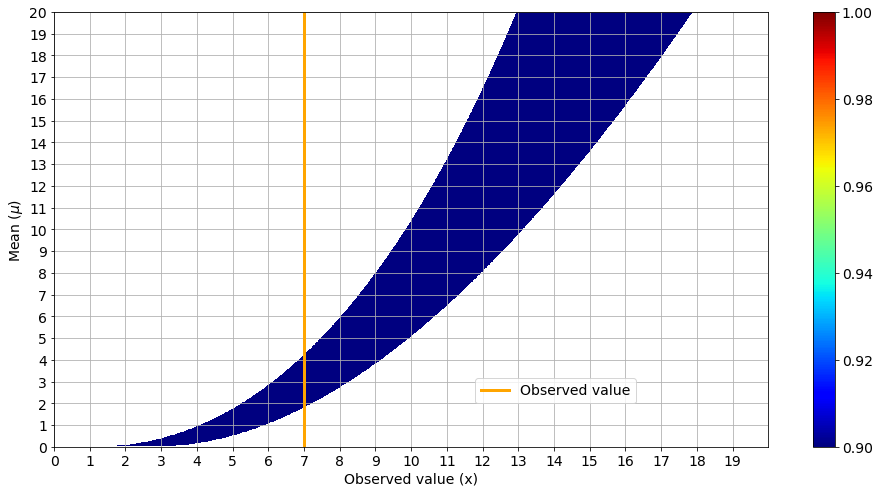

In [4]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 20.
max_x = 20
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, xp, p = get_central_interval(cl, 2. + 3. * pow( mean, 0.5 ), 0.5 + mean / max_mean) # use funny function for mean and linearly increasing sigma
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')


ax.plot([7.]*2,[0,max_mean], label='Observed value', color='orange', linewidth=3)
ax.legend(loc=[0.59,0.10])

plt.colorbar(norms)
plt.show()


### 10.1 Coverage

#### 10.1.1 Definition of coverage

The construction of confidence belts, which we discussed previously, is based on defining horizontal intervals according to a certain confidence level $C$. These can be constructed as central confidence intervals according to

$$P(x<x_1|\mu)=P(x>x_2|\mu)=(1-C)/2,$$

or as upper confidence limit intervals

$$P(x<x_1|\mu)=1-C.$$

For a given measured value of $x_0$, these then lead to an interval for $\mu$ with

$$P(\mu\in[\mu_1,\mu_2])=C.$$

This statement means that the unknown true value of $\mu$, $\mu_t$ lies within the interval $[\mu_1,\mu_2]$ in a fraction $C$ of the experiments conducted.

This equation being satisfied indicates that the intervals _cover_ $\mu$ at the stated confidence, or that they have the correct _coverage_.

Alternatively, the case when

$$P(\mu\in[\mu_1,\mu_2])<C,$$

is called _undercoverage_. This is a serious issue as this implies the existence of more information than is the case in reality.

Conversely,

$$P(\mu\in[\mu_1,\mu_2])>C,$$

is called _overcoverage_ , which is in most cases a less severe issue, but it leads to a loss of rejection power against false hypotheses. This case is sometimes called conservatism. Being conservative is never optimal and one should always strive to make estimates as accurate as possible.

#### Recap: Confidence levels from Gaussians

In the case of Gaussian distribution functions, the construction becomes very simple. The $x_-$ and $x_+$ curves become straight lines and the limits are obtained simply by $\mu_\pm=x_0\pm n\sigma$, where $n=1$ for 68% confidence level, $n=1.64$ for 90% confidence level, and so on.

This is a simplified case of the introductory example above.

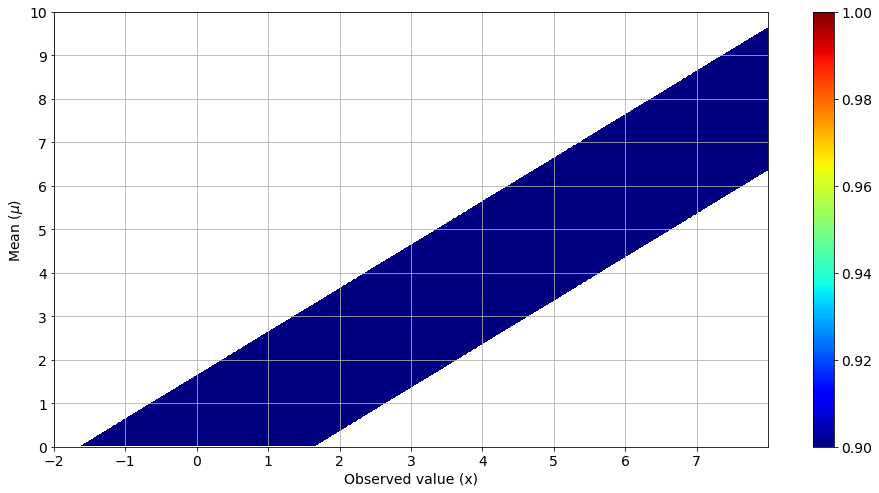

In [5]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, xp, p = get_central_interval(cl, mean, sigma) # use funny function for mean and linearly increasing sigma
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


#### 10.1.2 Measurement of a constrained quantity

Let usconsider the measurement of a mass. 

Assuming this measurement occurs with Gaussian uncertainties, we have the probability distribution function

$$P(x|\mu)=\frac{1}{\sqrt{2\pi}\sigma}e^{-(x-\mu)^2/2\sigma^2}.$$

The construction with a confidence belt fails miserably when a negative mass is measured with a relatively small uncertainty, e.g. $(-0.5\pm0.2)~$g. When trying to construct a 90% confidence interval, we would get $\mu_\pm=(-0.5\pm0.2\times 1.64)~$g, i.e. even $\mu_+=-0.172~$g remains negative.

A solution to this issue is a Bayesian construction with a normalisation that takes the physical limit into account. For example for positive masses, one gets

$$P(\mu|x)=\frac{e^{-(x-\mu)^2/2\sigma^2}}{\int_0^\infty e^{-(x-\mu')^2/2\sigma^2}d\mu'}(\mu>0).$$

This construction will then lead to one limit being zero, i.e. we set an upper limit. 

We will now discuss the limitations of this approach.

The Bayesian construction above leads to generally useful upper limits. Its main drawback is that its construction is not independent of the measured value; in fact, it is a vertical construction as the interval is calculated for each possible observed value. This does not a priori give control over the coverage of the horizontal intervals.

The colourscale in the plot below illustrates the horizontal coverage for the limit that is derived, i.e. if a measured value $x$ leads to a limit of $\mu$, the colour of the vertical band at $x$ corresponds to $\int_x^\infty {\rm Gauss}(x',\mu,\sigma)dx'$.

This shows that despite the vertical construction, the Bayesian formula ensures correct coverage or overcoverage, i.e. it avoids undercoverage.

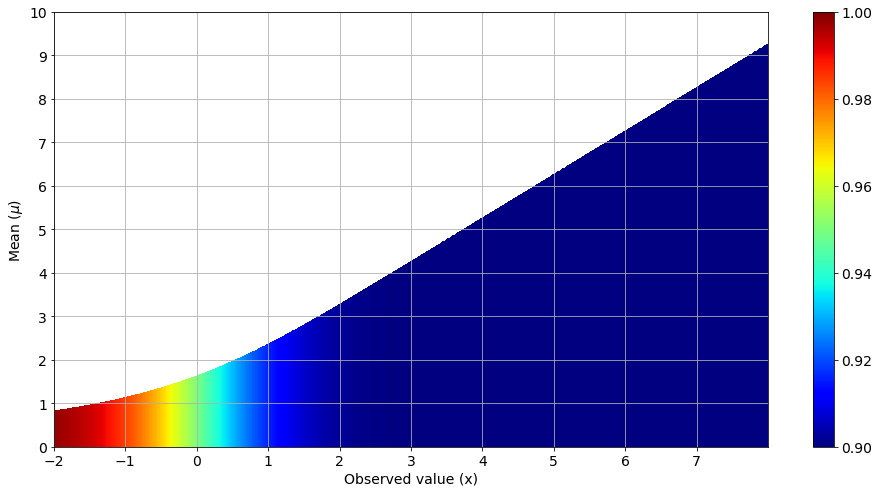

In [14]:
def get_bayesian_interval(cl, x, sig):
    # calculate interval of true mu according to Bayesian formula above
    denom = norm.cdf(x,0,sig)
    mup = norm.ppf((1-denom)+cl*denom, x, sig)
    p = 1.-norm.cdf(x,mup,sig)
    return mup, p

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    x = min_x + ( max_x - min_x ) * i / nSamples
    mum = 0
    mup, p = get_bayesian_interval(cl, x, sigma) 
    norm_patches.append( Rectangle((x,0),( max_x - min_x )/nSamples, mup-mum) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()

##### Limitations of central confidence belts

Let us continue to consider the example of a Gaussian probability density function.

If we decide _a priori_ to construct central intervals, we get the confidence belt already shown above.

This belt achieves correct coverage for all allowed values of $\mu$. However, as the measured value $x_0$ gets more and more negative the corresponding interval $\mu_\pm$ tends towards the empty set, which is reached for $x_0\le-1.64\sigma$.

This is clearly an unsatisfactory result. One alternative might be to continue the confidence belt to negative values of $\mu$, but this is similarly unsatisfactory as obtaining a set $\mu_\pm$ with a negative $\mu_-$ does not really make sense as we would know that any negative values of $\mu$ are unphysical.

Furthermore, the probability distribution function $P(x|\mu)$ may be ill-defined for negative $\mu$.

##### Limitations of upper confidence intervals

We can similarly to the previous case set out _a priori_ to construct upper limit intervals.

In this case the same problem arises for negative measured values with the continuation to negative values of $\mu$ being equally unsatisfactory.

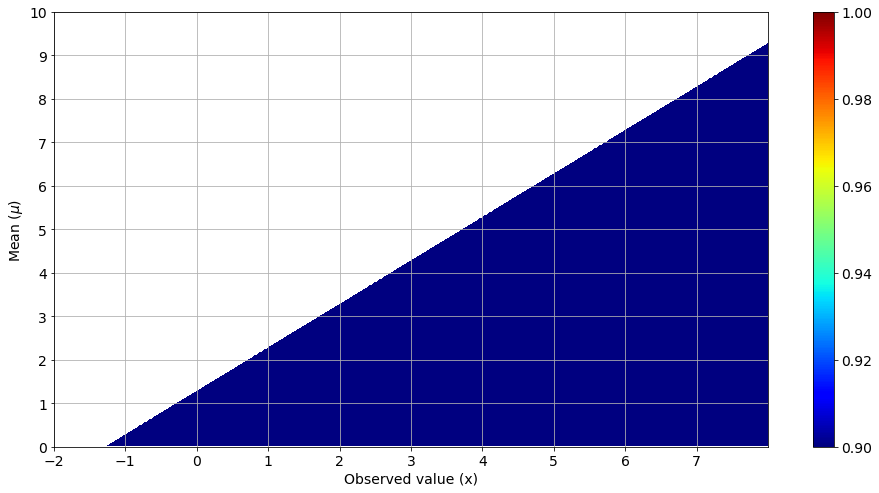

In [7]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp, norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

def get_upper_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(1-cl, mu, sig)
    return xm, 1.-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm, p = get_upper_interval(cl, mean, sigma) # use funny function for mean and linearly increasing sigma
    xp = max_x
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

### 10.2 The issue of flip-flopping

#### 10.2.1 Combining different approaches

As a remedy for not being able to quote intervals for negative measurement results one might decide to combine these approaches, for example according to the following recipe:
- For a measured value above $3\sigma$ we quote a central interval.
- For a less significant value we quote an upper limit.
- For a negative measured value we quote a constant upper limit, the same as for $x_0=0$.

This is illustrated below for 90% intervals.

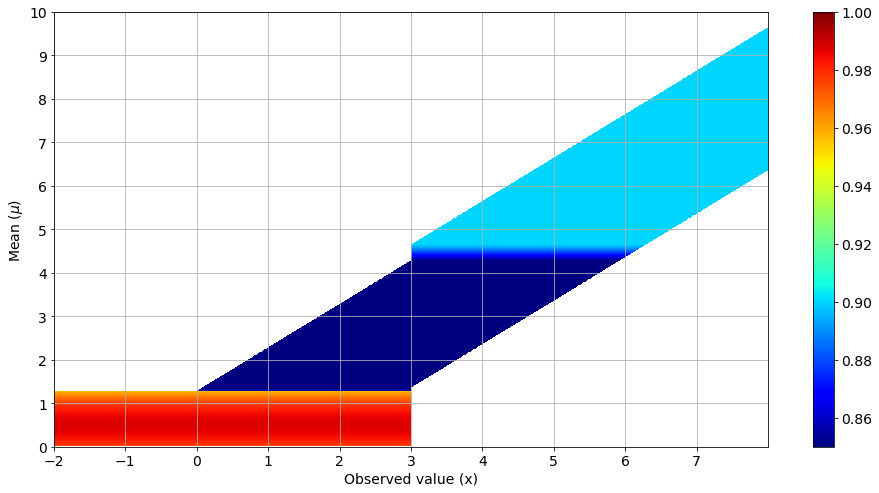

In [8]:
def get_central_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(0.5*(1-cl)     , mu, sig)
    xp = norm.ppf(0.5*(1-cl) + cl, mu, sig)
    return xm, xp

def get_upper_interval(cl, mu, sig):
    # calculate r- and r+ based on pre-defined functions
    xm = norm.ppf(1-cl, mu, sig)
    return xm

def get_prob(xm,xp,mu,sig):
    return norm.cdf(xp,mu,sig)-norm.cdf(xm,mu,sig)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
norm_patches = []
norm_colors = []
max_mean = 10.
min_x = -2.
max_x = 8.
sigma = 1.
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    xm_u = get_upper_interval(cl, mean, sigma) # x_minus for upper limit
    xm_c, xp_c = get_central_interval(cl, mean, sigma) # x_+/- for central interval
    if xm_c > 3:
        xm = xm_c
    elif xm_c <= 3 and xm_u > 3:
        xm = 3.
    elif xm_u > 0:
        xm = xm_u
    else:
        xm = min_x
    if xp_c > 3:
        xp = xp_c
    else:
        xp = 3.
    p = get_prob(xm,xp,mean,sigma)
    xp = min(xp, max_x)
    norm_patches.append( Rectangle((xm,mean),xp-xm,max_mean/nSamples) ) # define drawing object for confidence interval
    norm_colors.append(p)
norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.85, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(min_x,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/10. for x in range(11)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x))])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed value (x)')
ax.set_ylabel('Mean ($\mu$)')

plt.colorbar(norms)
plt.show()


#### 10.2.2 Flip-flopping

You should have received sufficient warnings about fully defining your procedure prior to performing the measurement that this measurement-dependent recipe should set off some alarm bells.

Let's have a look at the coverage of this approach.

For $\mu=2$ the coverage is too low as the right-hand limit is defined by the central interval belt, which appears to be shifted up compared to the upper limit belt. Therefore, the intervals undercover, which is problematic.

Also, considering $\mu=1$, it is apparent that the intervals overcover. More generally, for $\mu$ between $0$ and about $1.2$ the coverage obviously varies as the interval stays constant while $P(x|\mu)$ changes.


#### 10.2.3 Poisson belts

In the case of a counting experiment we have to use Poisson intervals, which have the particularity of leading to stair-like plots as they refer to a discrete distribution, i.e. we can only observe whole events.

In such experiments we are often interested in identifying a particular signal in the presence of background events.

The Poisson distribution function in the presence of a known amount of background, $b$, is

$$P(n|\mu,b)=e^{-(\mu+b)}\frac{(\mu+b)^n}{n!}.$$

As discussed before, when defining confidence intervals we rather overcover as we are in general unable to hit the desired confidence level exactly.

The following plots show the resulting confidence belts for central intervals and upper limits. They assume $b=3$.

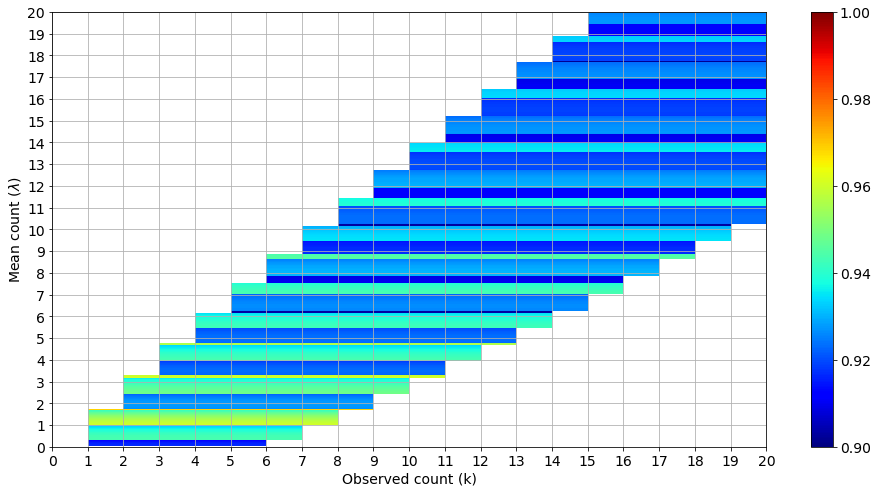

In [9]:
def get_central_interval(cl, l):
    # calculate r- and r+ based on pre-defined functions
    km = poisson.ppf(0.5*(1-cl)     , l)
    kp = poisson.ppf(0.5*(1-cl) + cl, l)
    if km > 0: 
        return km, kp, poisson.cdf(kp,l)-poisson.cdf(km-1,l)
    else:
        return km, kp, poisson.cdf(kp,l)

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 20
background = 3
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    km, kp, p = get_central_interval(cl, mean+background) # use fast implementation
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


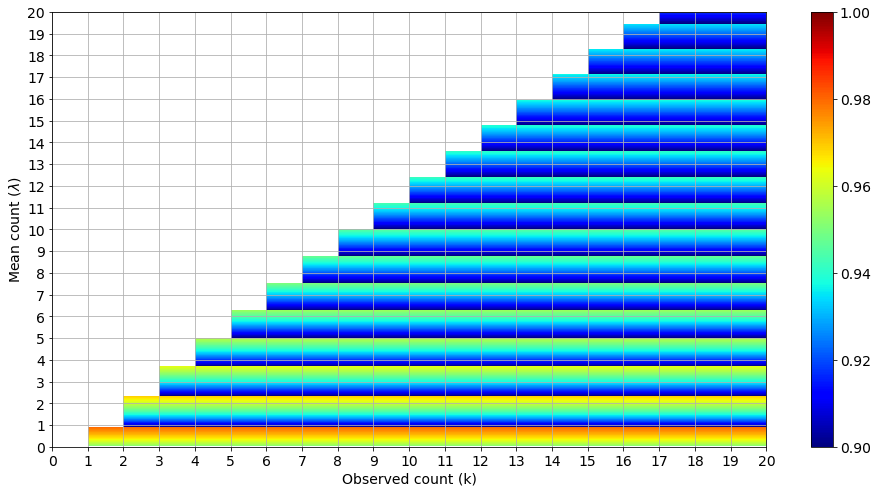

In [10]:
def get_upper_interval(cl, l):
    # calculate r- and r+ based on pre-defined functions
    km = poisson.ppf(1-cl, l)
    if km > 0: 
        return km, 1.-poisson.cdf(km-1,l)
    else:
        return km, 1.

cl = 0.9
nSamples = 1000 # defines granularity in y (=probability)
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 20
background = 3
for i in range(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    km, p = get_upper_interval(cl, mean+background) # use fast implementation
    kp = max_x
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

$~$

### 10.3 The Feldman-Cousins method

#### 10.3.1 Description of the method and application to Poisson intervals

The issue of flip-flopping is caused by the mixture of vertical and horizontal construction of the confidence intervals. It is therefore desirable to have an approach that solely depends on a horizontal construction.

A purely horizontal construction cannot a priori define whether it results in an interval or an upper limit as this is, in the end, a result of a vertical cut through the confidence belt at the measured value.

Feldman and Cousins proposed the following alternative approach. The method may appear a little contrived, but this is simply due to the fact that it is strictly restricted to a horizontal construction that does not pre-define whether a central interval or an upper limit is being constructed. 

The following example is based on a counting experiment (therefore involving Poisson distributions) with the presence of background.
This means that the total count $k$ will include a certain number $b$ of background events, where $b$ is assumed to be known.

It proceeds as follows:
- Consider the construction of a confidence interval of level $C$ for a given $\mu$.
- For each value of $k$ there is a value of $\mu$ that maximises $P(k|\mu)$ and this value shall be called $\mu_{\rm best}$.
- In our case this is simply $\mu_{\rm best}={\rm max}(0,k-b)$.
- Define the ratio $R=P(k|\mu)/P(k|\mu_{\rm best})$. Given that $\mu_{\rm best}$ maximises the probability distribution function, this ratio is between $0$ and $1$.
- Order all possible values of $k$ by their corresponding values of $R$ and, starting from the largest $R$, add the values of $k$ to the confidence interval until the sum of their probabilities exceeds $C$.

The relevant values for an example with $b=3$ and $\mu=0.5$ are given in the table below.
The probabilities of rank 1-7 add up to (compare the column 'CumulativeSum')

$$0.189+0.216+0.185+0.132+0.106+0.030+0.077 = 0.935,$$

which covers a 90% interval.

This construction leads to an automatic transition between one-sided and two-sided intervals and thereby gives a pre-defined transition from quoting a two-sided interval to an upper limit. Note that nowhere in this procedure does the observed number of events enter.

There are two caveats around the Feldman-Cousins method:
- In the case of having observed 0 events, a measurement with greater levels of expected background can lead to a lower upper limit compared to a measurement with fewer expected background events.
- The approach does not readily allow the inclusion of so-called nuisance parameters, which are used to account for systematic uncertainties. However, alternatives exist that mitigate this issue, but that's outside the scope of this course.

Below is the corresponding table of numbers to follow the method for $\mu=0.5$ and the complete confidence belt.

Calculating P(n|mu_best)
Calculating intervals


  2%|██▋                                                                                                                                                                            | 6/399 [00:00<00:07, 53.73it/s]

Table for mu =  0.5


  5%|████████▋                                                                                                                                                                     | 20/399 [00:00<00:06, 63.07it/s]

     k   P(k|mu) mu_best P(k|mu_best)         R CumulativeSum
4    4  0.188812       1     0.195367   0.96645      0.188812
3    3  0.215785       0     0.224042  0.963148      0.404598
2    2  0.184959       0     0.224042  0.825556      0.589557
5    5  0.132169       2     0.175467  0.753237      0.721725
1    1  0.105691       0     0.149361  0.707619      0.827416
0    0  0.030197       0     0.049787  0.606531      0.857614
6    6  0.077098       3     0.160623  0.479995      0.934712
7    7  0.038549       4     0.149003  0.258714      0.973261
8    8  0.016865       5     0.139587  0.120823      0.990126
9    9  0.006559       6     0.131756  0.049779      0.996685
10  10  0.002296       7      0.12511  0.018348      0.998981
11  11   0.00073       8     0.119378  0.006118      0.999711
12  12  0.000213       9     0.114368  0.001863      0.999924
13  13  0.000057      10      0.10994  0.000522      0.999981
14  14  0.000014      11     0.105989  0.000135      0.999996
15  15  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:05<00:00, 67.51it/s]


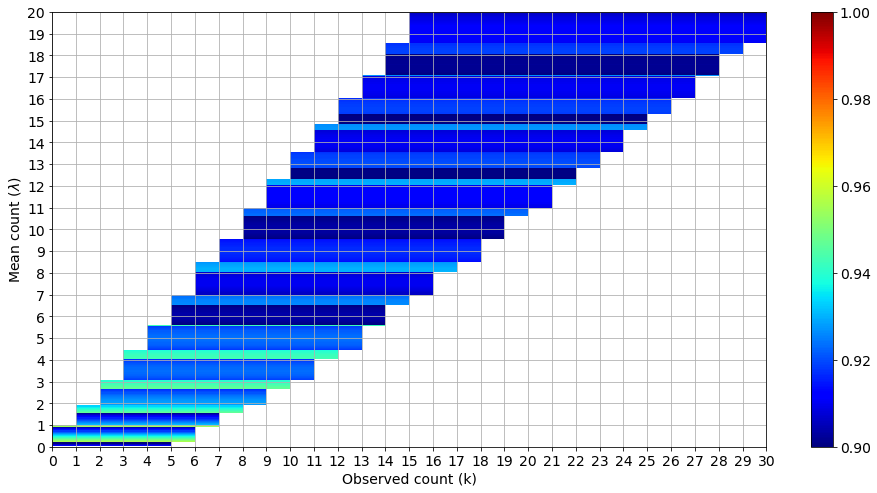

In [11]:
def get_prob(km,kp,l):
    if km > 0:
        return poisson.cdf(kp,l)-poisson.cdf(km-1,l)
    else:
        return poisson.cdf(kp,l)

cl = 0.9
nSamples = 400 # defines granularity in y, takes about 0.05s per sample
poisson_patches = []
poisson_colors = []
max_mean = 20.
max_x = 30
background = 3

print('Calculating P(n|mu_best)')
p_mubest = []
for k in range(max_x+1):
    mubest = max(0,k-background)
    p_mubest.append(poisson.pmf(k,mubest+background))

print('Calculating intervals')
for i in trange(1,nSamples):
    mean = max_mean * i / nSamples # translate into probability
    FC_table = pd.DataFrame(columns=['k','P(k|mu)','mu_best','P(k|mu_best)'])
    tmp = [FC_table]
    for k in range(max_x+1):
            mubest = max(0,k-background)
            p_this = poisson.pmf(k,mean+background)
            p_best = p_mubest[k]
            #print(mean,k,mubest,p_best,p_this)
            if 0 < p_best:
                #FC_table = FC_table.concat({'k':k,'P(k|mu)':p_this,'mu_best':mubest,'P(k|mu_best)':p_best}, ignore_index=True)
                tmp.append(pd.DataFrame({'k':k,'P(k|mu)':p_this,'mu_best':mubest,'P(k|mu_best)':p_best},index=[k]))
    FC_table = pd.concat(tmp, ignore_index=True)
    FC_table['R'] = FC_table['P(k|mu)'] / FC_table['P(k|mu_best)']
    FC_table = FC_table.sort_values('R',ascending = False)
    FC_table['CumulativeSum'] = FC_table['P(k|mu)'].cumsum()
    if 10 == i: 
        print('Table for mu = ',mean)
        print(FC_table)
    good_ks = FC_table.query('CumulativeSum < @cl')['k'].values
    good_ks = np.hstack([good_ks, FC_table.query('CumulativeSum >= @cl').head(1)['k'].values])
    #print(good_ks)
    km = good_ks.min()
    kp = good_ks.max()
    p = get_prob(km, kp, mean+background)
    kp = min(kp,max_x)
    poisson_patches.append( Rectangle((km,mean),kp-km,max_mean/nSamples) ) # define drawing object for confidence interval
    poisson_colors.append(p)
poissons = PatchCollection(poisson_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
poissons.set_array(np.array(poisson_colors))
poissons.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(poissons) # draw belt

# plot optics
ax.set_yticks([max_mean*x/20. for x in range(21)])
ax.set_xticks([x for x in range(max_x+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Observed count (k)')
ax.set_ylabel('Mean count ($\lambda$)')

plt.colorbar(poissons)
plt.show()


#### 10.3.2 Application to Gaussian confidence belts

For a Gaussian (i.e. continuous) variable the procedure is very similar. In short, it is:

- For a Gaussian distributed variable $\mu$ with boundary condition $\mu\ge0$, find the value of $\mu$ for which $P(x|\mu)$ is maximal and call this $\mu_{\rm best}$. This is given by $\mu_{\rm best}={\rm max}(0,x)$.

- Define the likelihood ratio

$$R(x)=\frac{P(x|\mu)}{P(x|\mu_{\rm best})}.$$

- For a given $\mu$ find the interval $[x_1,x_2]$ such that $R(x_1)=R(x_2)$ and $\int_{x_1}^{x_2}P(x|\mu)dx=C$, with $C$ the desired confidence level. This integral gives the accepted range for each value of $\mu$.

The condition $R(x_1)=R(x_2)$ replaces the explicit ordering and, provided that $R(x)$ is continuously falling on either side of $x=\mu_{\rm best}$, it uniquely defines the interval $[x_1,x_2]$ for a given $C$.

At $x=1.28$ the distribution transitions from a one-sided to a two-sided interval.

The full confidence belt is shown in the following plot.

##### Computation requirements

The continuous case requires calculating and sorting many values in $x$ for each value in $\mu$. The exact number is defined by the desired resolution of the plot. 

The plot below already takes several minutes to compute while it is based on a simple Gaussian function. However, here we knew the correct values for $\mu_{\rm best}$ a priori.

If $\mu_{\rm best}$ needs to be calculated, this can add considerable computation requirements.

In reality, this method is likely to be applied to much more complex probability densitiy functions, which take significantly longer to evaluate. Therefore, it can be computationally challenging to obtain a result with the Feldman-Cousins method.

Calculating P(n|mu_best)
Calculating intervals


  1%|██▏                                                                                                                                                                            | 5/399 [00:01<01:38,  3.99it/s]

Table for mu =  0.075
          x   P(x|mu) mu_best P(x|mu_best)         R CumulativeSum
166   0.075  0.398942   0.075     0.398942       1.0      0.004987
167  0.0875  0.398911  0.0875     0.398942  0.999922      0.009973
165  0.0625  0.398911  0.0625     0.398942  0.999922       0.01496
168     0.1  0.398818     0.1     0.398942  0.999688      0.019945
164    0.05  0.398818    0.05     0.398942  0.999688       0.02493
..      ...       ...     ...          ...       ...           ...
795  7.9375       0.0  7.9375     0.398942       0.0      0.981295
796    7.95       0.0    7.95     0.398942       0.0      0.981295
797  7.9625       0.0  7.9625     0.398942       0.0      0.981295
798   7.975       0.0   7.975     0.398942       0.0      0.981295
799  7.9875       0.0  7.9875     0.398942       0.0      0.981295

[800 rows x 6 columns]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [01:36<00:00,  4.15it/s]


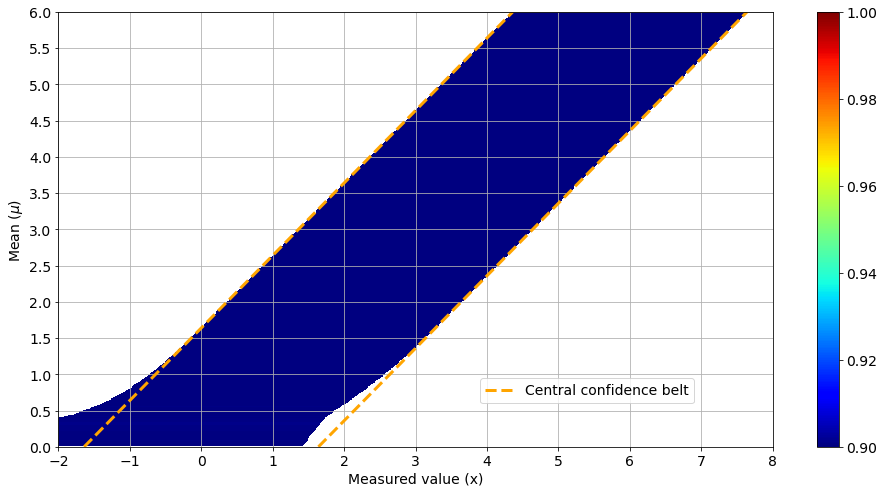

In [24]:
def get_prob(xm,xp,mu,sigma):
    return norm.cdf(xp,mu,sigma)-norm.cdf(xm,mu,sigma)

cl = 0.9
nSamplesX = 800 # defines granularity in x
nSamplesY = 400 # defines granularity in y, takes a bit less than 1s per sample
norm_patches = []
norm_colors = []
max_mean = 6.0
min_x = -2.
max_x = 8.
sigma = 1.
binw = (max_x - min_x) / nSamplesX

print('Calculating P(n|mu_best)')
p_mubest = []
for i in range(nSamplesX):
    x = min_x + i / nSamplesX * (max_x - min_x)
    mubest = max(0, x)
    p_mubest.append(norm.pdf(x,mubest,sigma))

print('Calculating intervals')
for i in trange(1,nSamplesY):
    mean = max_mean * i / nSamplesY # translate into probability
    FC_table = pd.DataFrame(columns=['x','P(x|mu)','mu_best','P(x|mu_best)'])
    tmp = [FC_table]
    for j in range(nSamplesX):
        x = min_x + j / nSamplesX * (max_x - min_x)
        mubest = max(0, x)
        p_this = norm.pdf(x,mean,sigma)
        p_best = p_mubest[j]
        if 0 < p_best:
            #FC_table = FC_table.append({'x':x,'P(x|mu)':p_this,'mu_best':mubest,'P(x|mu_best)':p_best}, ignore_index=True)
            tmp.append(pd.DataFrame({'x':x,'P(x|mu)':p_this,'mu_best':mubest,'P(x|mu_best)':p_best},index=[j]))
    FC_table = pd.concat(tmp, ignore_index=True)
    FC_table['R'] = FC_table['P(x|mu)'] / FC_table['P(x|mu_best)']
    FC_table = FC_table.sort_values('R',ascending = False)
    FC_table['CumulativeSum'] = FC_table['P(x|mu)'].cumsum()*binw
    if 5 == i: 
        print('Table for mu = ',mean)
        print(FC_table)
    good_xs = FC_table.query('CumulativeSum < @cl')['x'].values
    good_xs = np.hstack([good_xs, FC_table.query('CumulativeSum >= @cl').head(1)['x'].values])
    xm = good_xs.min()
    xp = good_xs.max()
    p = get_prob(xm, xp, mean,sigma)
    xm = max(xm,min_x)
    xp = min(xp,max_x)
    norm_patches.append( Rectangle((xm,mean-max_mean/nSamplesY/2.),xp-xm,max_mean/nSamplesY) ) # define drawing object for confidence interval
    norm_colors.append(p)

norms = PatchCollection(norm_patches, alpha=1.0, cmap=jet) # drawing object for complete belt
norms.set_array(np.array(norm_colors))
norms.set_clim([0.9, 1])

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xlim(0,max_x) # set x axis range
ax.set_ylim(0,max_mean)         # set y axis range

ax.add_collection(norms) # draw belt

# plot optics
ax.set_yticks([max_mean*x/12. for x in range(13)])
ax.set_xticks([min_x + x for x in range(ceil(max_x-min_x)+1)])
ax.grid(which='both',axis='x')
ax.grid(which='major',axis='y')
ax.set_xlabel('Measured value (x)')
ax.set_ylabel('Mean ($\mu$)')

ax.plot([-1.64,max_mean-1.64],[0,max_mean],color='orange',linewidth=3,linestyle='--',label='Central confidence belt')
ax.plot([1.64,max_mean+1.64],[0,max_mean],color='orange',linewidth=3,linestyle='--')
ax.legend(loc=[0.59,0.10])

plt.colorbar(norms)
plt.show()

<div class="well" align="center">
    <div class="container-fluid">
        <div class="row">
            <div class="col-md-3" align="center">
                <img align="center" alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" width="60%">
            </div>
            <div class="col-md-8">
            This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>).
            </div>
        </div>
    </div>
    <br>
    <br>
    <i>Note: The content of this Jupyter Notebook is provided for educational purposes only.</i>
</div>